In [1]:
import pandas as pd
import numpy as np

# Load the CSV you exported from Mongo/Compass
df = pd.read_csv("snrt_db.features_sites_v1.csv")

# --- Basic hygiene ---
# Ensure the columns we’ll use exist (skip silently if not in file)
expected_cols = [
    "site_id","Site","Province","Region","SNRT_RS","Latitude","Longitude","Altitude",
    "has_station","amctl_cnt","climctl_cnt","fmctl_cnt","gectl_cnt","tntctl_cnt",
    "upsctl_cnt","counterctl_cnt","brigades_cnt","brigades_present","ctl_total"
]
missing = [c for c in expected_cols if c not in df.columns]
print("Missing columns:", missing)

# Keep only rows that have lat/lon
df = df.dropna(subset=["Latitude","Longitude"]).copy()

# Convert some to numeric just in case
for c in ["Altitude","Latitude","Longitude","ctl_total","brigades_cnt"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")


Missing columns: []


In [2]:
# Haversine (km) — vectorized friendly
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088  # mean Earth radius in km
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))


In [3]:
# --- Compute distances to stations ---
stations = df[df["has_station"] == 1][["site_id","Latitude","Longitude"]].reset_index(drop=True)
sites    = df[["site_id","Latitude","Longitude"]].reset_index(drop=True)

if stations.empty:
    print("⚠️ No stations found in dataset – distance features will be NaN.")
    df["dist_to_nearest_station_km"] = np.nan
    df["mean_dist_to_3_stations_km"] = np.nan
else:
    lat1 = sites["Latitude"].values[:, None]
    lon1 = sites["Longitude"].values[:, None]
    lat2 = stations["Latitude"].values[None, :]
    lon2 = stations["Longitude"].values[None, :]

    D = haversine_km(lat1, lon1, lat2, lon2)

    nearest = np.partition(D, kth=0, axis=1)[:, 0]  # min distance
    k = min(3, D.shape[1])
    mean3 = np.mean(np.partition(D, kth=range(k), axis=1)[:, :k], axis=1)

    df = df.merge(
        pd.DataFrame({
            "site_id": sites["site_id"].values,
            "dist_to_nearest_station_km": nearest,
            "mean_dist_to_3_stations_km": mean3
        }),
        on="site_id", how="left"
    )

print("✅ Added distance features")
df[["site_id","Site","dist_to_nearest_station_km","mean_dist_to_3_stations_km"]].head()


✅ Added distance features


,site_id,Site,dist_to_nearest_station_km,mean_dist_to_3_stations_km
0,1,Abteh,0.0,64.561875
1,2,Aday,0.0,12.145752
2,3,Adrej,0.0,16.171325
3,4,Afourar,0.0,40.860188
4,5,Afra-ait-khalfoun,0.0,9.967190


In [4]:
# --- Regional aggregation ---
df["brigades_present"] = pd.to_numeric(df.get("brigades_present", 0), errors="coerce").fillna(0).astype(int)
df["brigades_cnt"]     = pd.to_numeric(df.get("brigades_cnt", 0), errors="coerce").fillna(0)
df["ctl_total"]        = pd.to_numeric(df.get("ctl_total", 0), errors="coerce").fillna(0)

grp = df.groupby("Region", dropna=False)
region_stats = grp.agg(
    region_sites=("site_id","count"),
    region_brigade_presence_rate=("brigades_present","mean"),
    region_brigades_per_site=("brigades_cnt","mean"),
    region_ctl_mean=("ctl_total","mean"),
    region_ctl_std=("ctl_total","std")
).reset_index()

df = df.merge(region_stats, on="Region", how="left")
df["ctl_total_zscore"] = (df["ctl_total"] - df["region_ctl_mean"]) / df["region_ctl_std"].replace(0, np.nan)

print("✅ Added regional features")
df[["site_id","Site","Region","region_brigade_presence_rate","ctl_total","ctl_total_zscore"]].head()


✅ Added regional features


,site_id,Site,Region,region_brigade_presence_rate,ctl_total,ctl_total_zscore
0,1,Abteh,Guelmim-Oued Noun,0.086957,0,NaN
1,2,Aday,Guelmim-Oued Noun,0.086957,0,NaN
2,3,Adrej,Fès-Meknès,0.142857,0,NaN
3,4,Afourar,Beni Mellal-Khénifra,0.034483,0,NaN
4,5,Afra-ait-khalfoun,Darâa-Tafilalet,0.048780,0,NaN


In [5]:
# ---- Altitude bin (low / mid / high) + make sure numeric types are safe
for c in ["Altitude","Latitude","Longitude","ctl_total","brigades_cnt"]:
    if c in df:
        df[c] = pd.to_numeric(df[c], errors="coerce")

def altitude_bin_func(a):
    if pd.isna(a): 
        return "unknown"
    if a < 200: 
        return "low"
    if a < 800: 
        return "mid"
    return "high"

df["altitude_bin"] = df["Altitude"].apply(altitude_bin_func).astype("category")
df["has_station"]  = pd.to_numeric(df.get("has_station", 0), errors="coerce").fillna(0).astype(int)

print("✅ Altitude bin & numeric coercion done.")
df[["site_id","Site","Altitude","altitude_bin","has_station"]].head()


✅ Altitude bin & numeric coercion done.


,site_id,Site,Altitude,altitude_bin,has_station
0,1,Abteh,96,low,1
1,2,Aday,707,mid,1
2,3,Adrej,985,high,1
3,4,Afourar,449,mid,1
4,5,Afra-ait-khalfoun,955,high,1


In [6]:
# ---- Ratio / density features
# region_sites already computed; build a few helpful ratios
df["ctl_per_site_in_region"] = (df["region_ctl_mean"]).fillna(0)

# brigade intensity: brigades per site at region level + binary presence
df["region_brigades_per_site"] = df["region_brigades_per_site"].fillna(0)
df["brigade_presence_ratio_reg"] = df["region_brigade_presence_rate"].fillna(0)

# per-site normalized "activity" proxy
df["ctl_total_norm_reg"] = (df["ctl_total"] / df["region_ctl_mean"].replace(0, np.nan)).replace([np.inf,-np.inf], np.nan)
df["ctl_total_norm_reg"] = df["ctl_total_norm_reg"].fillna(0)

print("✅ Ratios / densities added.")
df[["site_id","Region","ctl_total","region_ctl_mean","ctl_total_norm_reg",
    "region_brigades_per_site","brigade_presence_ratio_reg"]].head()


✅ Ratios / densities added.


,site_id,Region,ctl_total,region_ctl_mean,ctl_total_norm_reg,region_brigades_per_site,brigade_presence_ratio_reg
0,1,Guelmim-Oued Noun,0,0.0,0.0,4.217391,0.086957
1,2,Guelmim-Oued Noun,0,0.0,0.0,4.217391,0.086957
2,3,Fès-Meknès,0,0.0,0.0,6.942857,0.142857
3,4,Beni Mellal-Khénifra,0,0.0,0.0,1.655172,0.034483
4,5,Darâa-Tafilalet,0,0.0,0.0,2.463415,0.048780


In [7]:
# ---- Distance flags + simple interactions
# If there are **no** stations in the whole dataset, these will already be NaN.
near_km = 20.0  # tweakable threshold

df["dist_to_nearest_station_km"] = pd.to_numeric(df["dist_to_nearest_station_km"], errors="coerce")
df["mean_dist_to_3_stations_km"] = pd.to_numeric(df["mean_dist_to_3_stations_km"], errors="coerce")

df["is_far_from_any_station"] = (df["dist_to_nearest_station_km"] > near_km).astype("Int64")
df.loc[df["dist_to_nearest_station_km"].isna(), "is_far_from_any_station"] = pd.NA

# interactions capturing "need" vs "supply":
df["far_x_brigade_presence"] = df["is_far_from_any_station"].fillna(0).astype(int) * df["brigades_present"].fillna(0).astype(int)
df["ctl_x_distance"] = df["ctl_total"].fillna(0) * df["dist_to_nearest_station_km"].fillna(df["dist_to_nearest_station_km"].median())

print("✅ Distance flags & interactions added.")
df[["site_id","dist_to_nearest_station_km","is_far_from_any_station","far_x_brigade_presence","ctl_x_distance"]].head()


✅ Distance flags & interactions added.


,site_id,dist_to_nearest_station_km,is_far_from_any_station,far_x_brigade_presence,ctl_x_distance
0,1,0.0,0,0,0.0
1,2,0.0,0,0,0.0
2,3,0.0,0,0,0.0
3,4,0.0,0,0,0.0
4,5,0.0,0,0,0.0


In [8]:
# ---- One-hot encode altitude bin (keeps model simple & linear)
altitude_dummies = pd.get_dummies(df["altitude_bin"], prefix="alt", dummy_na=False)
df = pd.concat([df, altitude_dummies], axis=1)

# ---- Define the feature list (feel free to add/remove)
feature_cols = [
    # geography / proximity
    "dist_to_nearest_station_km", "mean_dist_to_3_stations_km", "is_far_from_any_station",
    # site activity
    "ctl_total", "ctl_total_norm_reg",
    # brigades
    "brigades_cnt", "brigades_present", "region_brigades_per_site", "brigade_presence_ratio_reg",
    # interactions
    "far_x_brigade_presence", "ctl_x_distance",
    # altitude one-hot
] + [c for c in df.columns if c.startswith("alt_")]

# Safety: create any missing columns with 0 (in case some dummies don’t exist)
for c in feature_cols:
    if c not in df.columns:
        df[c] = 0

X = df[feature_cols].copy()
y = df["has_station"].astype(int).values

# Final NA handling (fill numeric NAs with column medians)
X = X.apply(lambda s: s.fillna(s.median()) if s.dtype.kind in "fc" else s.fillna(0))

print("✅ Feature matrix built.")
print("Features:", feature_cols)
print("X shape:", X.shape, "| y shape:", y.shape)


✅ Feature matrix built.
Features: ['dist_to_nearest_station_km', 'mean_dist_to_3_stations_km', 'is_far_from_any_station', 'ctl_total', 'ctl_total_norm_reg', 'brigades_cnt', 'brigades_present', 'region_brigades_per_site', 'brigade_presence_ratio_reg', 'far_x_brigade_presence', 'ctl_x_distance', 'alt_high', 'alt_low', 'alt_mid']
X shape: (291, 14) | y shape: (291,)


In [9]:
# E) Train/validate

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

# Train/valid split (keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Pipeline: Standardize then Logistic Regression
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(
        class_weight="balanced",      # helps if 0/1 is imbalanced
        max_iter=2000,
        solver="lbfgs",               # good default
        n_jobs=None
    ))
])

# CV (ROC-AUC) on the training split
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=cv)
print(f"CV ROC-AUC (train, 5-fold): mean={cv_auc.mean():.3f}  std={cv_auc.std():.3f}")

# Fit and evaluate on the hold-out test
pipe.fit(X_train, y_train)

proba_has_test = pipe.predict_proba(X_test)[:, 1]     # P(has_station=1)
pred_has_test   = (proba_has_test >= 0.5).astype(int)

print("\nHold-out results")

auc = roc_auc_score(y_test, proba_has_test)
acc = accuracy_score(y_test, pred_has_test)
cm  = confusion_matrix(y_test, pred_has_test)
rep = classification_report(y_test, pred_has_test, digits=3)

print(f"ROC-AUC : {auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print("Confusion matrix (y=true rows, yhat=cols):\n", cm)
print("\nClassification report:\n", rep)



CV ROC-AUC (train, 5-fold): mean=0.894  std=0.027

Hold-out results
ROC-AUC : 0.954
Accuracy: 0.904
Confusion matrix (y=true rows, yhat=cols):
 [[24  4]
 [ 3 42]]

Classification report:
               precision    recall  f1-score   support

           0      0.889     0.857     0.873        28
           1      0.913     0.933     0.923        45

    accuracy                          0.904        73
   macro avg      0.901     0.895     0.898        73
weighted avg      0.904     0.904     0.904        73



,feature,coef,abs_importance
2,is_far_from_any_station,-2.082757,2.082757
5,brigades_cnt,1.054811,1.054811
1,mean_dist_to_3_stations_km,-0.606979,0.606979
0,dist_to_nearest_station_km,-0.583721,0.583721
6,brigades_present,-0.580941,0.580941
12,alt_low,-0.489945,0.489945
11,alt_high,0.415672,0.415672
8,brigade_presence_ratio_reg,0.344494,0.344494
7,region_brigades_per_site,0.184344,0.184344
9,far_x_brigade_presence,-0.088179,0.088179


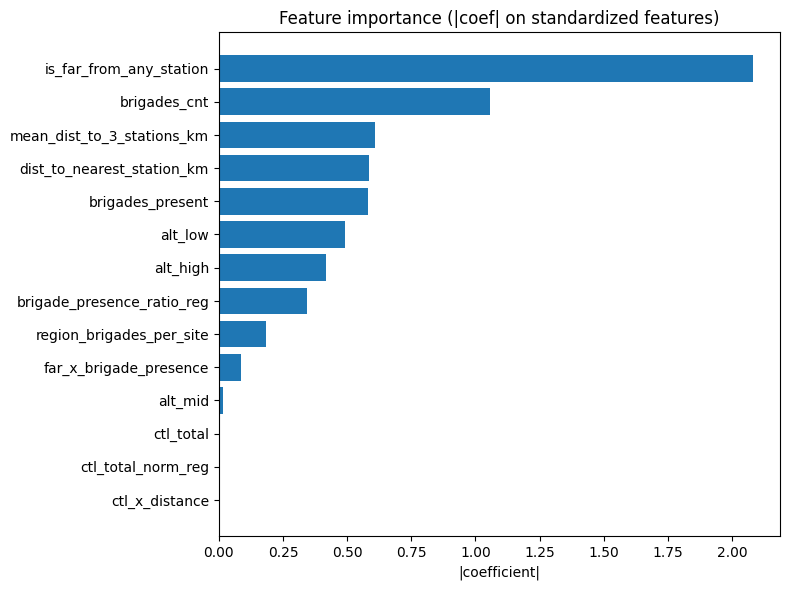

In [10]:
# F) Coefficient-based importances (after standardization)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract fitted pieces
scaler = pipe.named_steps["scaler"]
logit  = pipe.named_steps["logit"]

# Names after scaling == original columns
coef = logit.coef_.ravel()
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "coef": coef,
    "abs_importance": np.abs(coef)
}).sort_values("abs_importance", ascending=False)

display(feat_imp.head(20))

# Plot top-15 by absolute magnitude
topn = 15
plt.figure(figsize=(8,6))
plt.barh(feat_imp.head(topn)["feature"][::-1], feat_imp.head(topn)["abs_importance"][::-1])
plt.title("Feature importance (|coef| on standardized features)")
plt.xlabel("|coefficient|")
plt.tight_layout()
plt.show()


In [11]:
# G) Score every site
proba_has_all = pipe.predict_proba(X)[:, 1]
need_score = 1.0 - proba_has_all

sc = scaler
X_std = pd.DataFrame(sc.transform(X), columns=X.columns, index=X.index)

# Per-feature contributions to the logit margin for "has" class
# margin = intercept + sum_i (x_std_i * coef_i)
intercept = float(logit.intercept_)
contrib_has = X_std * coef  # DataFrame same shape as X

# For "need" (no-station) explanations, invert sign:
contrib_need = -contrib_has

def top_explanations(row_contrib: pd.Series, top=3):
    # pick features with largest positive contributions to "need"
    s = row_contrib.sort_values(ascending=False)
    s = s[s.abs() > 1e-9]
    return "; ".join([f"{k} (+{v:.2f})" for k, v in s.head(top).items()])

# Assemble results
rank = df.copy()
rank["proba_has"]  = proba_has_all
rank["need_score"] = need_score

# explanations (top driving factors for "need")
expl_list = []
for i in rank.index:
    expl_list.append(top_explanations(contrib_need.loc[i], top=3))
rank["explanations"] = expl_list

# Useful view (top-20 by need)
cols_show = [
    "site_id","Site","Province","Region","SNRT_RS","Latitude","Longitude","Altitude","altitude_bin",
    "dist_to_nearest_station_km","ctl_total","brigades_cnt","brigades_present",
    "need_score","proba_has","explanations","has_station"
]
top20 = (
    rank
    .sort_values("need_score", ascending=False)[cols_show]
    .head(20)
)
display(top20)


/var/folders/3g/m0q48k790z905plz0t3x_wfm0000gn/T/ipykernel_59435/2502893982.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = float(logit.intercept_)


,site_id,Site,Province,Region,SNRT_RS,Latitude,Longitude,Altitude,altitude_bin,dist_to_nearest_station_km,ctl_total,brigades_cnt,brigades_present,need_score,proba_has,explanations,has_station
283,304,Tarfaya Municipalité,Tarfaya,-,NaN,0.000000,0.000000,0,low,3146.213095,0,0,0,1.000000,1.169340e-07,mean_dist_to_3_stations_km (+4.99); dist_to_ne...,0
284,305,Hansala,-,-,NaN,0.000000,0.000000,0,low,3146.213095,0,0,0,1.000000,1.169340e-07,mean_dist_to_3_stations_km (+4.99); dist_to_ne...,0
290,311,Reg RABAT,Rabat,Rabat-Salé-Kénitra,NaN,0.000000,0.000000,0,low,3146.213095,0,0,0,1.000000,2.290405e-07,mean_dist_to_3_stations_km (+4.99); dist_to_ne...,0
212,223,Biougra,Chtouka Ait Baha,Sous-Massa,Agadir,0.000000,0.000000,0,low,3146.213095,0,47,1,1.000000,3.428744e-07,mean_dist_to_3_stations_km (+4.99); dist_to_ne...,0
287,308,sidi ahmed ben rahal,Sidi Bennour,Grand Casablanca-Settat,NaN,0.000000,0.000000,0,low,3146.213095,0,0,0,1.000000,4.797189e-07,mean_dist_to_3_stations_km (+4.99); dist_to_ne...,0
267,287,El Mehbes 2 AM,Assa-Zag,Zone Militaire,NaN,27.686370,8.871500,474,mid,1094.055372,0,0,0,0.999757,2.432217e-04,is_far_from_any_station (+3.77); mean_dist_to_...,0
276,297,Bir gandouz,Dakhla,Zone Militaire,NaN,21.600609,-16.464819,0,low,238.996024,0,0,0,0.999129,8.709760e-04,is_far_from_any_station (+3.77); alt_low (+0.8...,0
278,299,Tichla,Aousred,Zone Militaire,NaN,21.582323,-14.971834,0,low,254.697775,0,0,0,0.999109,8.914958e-04,is_far_from_any_station (+3.77); alt_low (+0.8...,0
279,300,Oum driga,Aousred,Zone Militaire,NaN,24.112274,-13.269577,0,low,249.512542,0,0,0,0.998794,1.206214e-03,is_far_from_any_station (+3.77); alt_low (+0.8...,0
277,298,Beggari,Dakhla,Zone Militaire,NaN,23.707363,-14.067634,0,low,190.094669,0,0,0,0.998675,1.324822e-03,is_far_from_any_station (+3.77); alt_low (+0.8...,0


In [12]:
top20_candidates = (
    rank[rank["has_station"] == 0]
    .sort_values("need_score", ascending=False)[cols_show]
    .head(20)
)
display(top20_candidates)


,site_id,Site,Province,Region,SNRT_RS,Latitude,Longitude,Altitude,altitude_bin,dist_to_nearest_station_km,ctl_total,brigades_cnt,brigades_present,need_score,proba_has,explanations,has_station
283,304,Tarfaya Municipalité,Tarfaya,-,NaN,0.000000,0.000000,0,low,3146.213095,0,0,0,1.000000,1.169340e-07,mean_dist_to_3_stations_km (+4.99); dist_to_ne...,0
284,305,Hansala,-,-,NaN,0.000000,0.000000,0,low,3146.213095,0,0,0,1.000000,1.169340e-07,mean_dist_to_3_stations_km (+4.99); dist_to_ne...,0
290,311,Reg RABAT,Rabat,Rabat-Salé-Kénitra,NaN,0.000000,0.000000,0,low,3146.213095,0,0,0,1.000000,2.290405e-07,mean_dist_to_3_stations_km (+4.99); dist_to_ne...,0
212,223,Biougra,Chtouka Ait Baha,Sous-Massa,Agadir,0.000000,0.000000,0,low,3146.213095,0,47,1,1.000000,3.428744e-07,mean_dist_to_3_stations_km (+4.99); dist_to_ne...,0
287,308,sidi ahmed ben rahal,Sidi Bennour,Grand Casablanca-Settat,NaN,0.000000,0.000000,0,low,3146.213095,0,0,0,1.000000,4.797189e-07,mean_dist_to_3_stations_km (+4.99); dist_to_ne...,0
267,287,El Mehbes 2 AM,Assa-Zag,Zone Militaire,NaN,27.686370,8.871500,474,mid,1094.055372,0,0,0,0.999757,2.432217e-04,is_far_from_any_station (+3.77); mean_dist_to_...,0
276,297,Bir gandouz,Dakhla,Zone Militaire,NaN,21.600609,-16.464819,0,low,238.996024,0,0,0,0.999129,8.709760e-04,is_far_from_any_station (+3.77); alt_low (+0.8...,0
278,299,Tichla,Aousred,Zone Militaire,NaN,21.582323,-14.971834,0,low,254.697775,0,0,0,0.999109,8.914958e-04,is_far_from_any_station (+3.77); alt_low (+0.8...,0
279,300,Oum driga,Aousred,Zone Militaire,NaN,24.112274,-13.269577,0,low,249.512542,0,0,0,0.998794,1.206214e-03,is_far_from_any_station (+3.77); alt_low (+0.8...,0
277,298,Beggari,Dakhla,Zone Militaire,NaN,23.707363,-14.067634,0,low,190.094669,0,0,0,0.998675,1.324822e-03,is_far_from_any_station (+3.77); alt_low (+0.8...,0


In [13]:
out_csv = "ranked_site_need_predictions.csv"
rank.sort_values("need_score", ascending=False)[cols_show].to_csv(out_csv, index=False)
print("Saved:", out_csv)


Saved: ranked_site_need_predictions.csv


In [14]:
import joblib
joblib.dump(pipe, "logit_site_has_station.pkl")
print("Model saved: logit_site_has_station.pkl")


Model saved: logit_site_has_station.pkl


In [15]:
pipe2 = joblib.load("logit_site_has_station.pkl")
